# Notebook: Augmentation methods for Pill Images

+ Made by: Phuc Nguyen & Tommy Ngx 
+ Date created: Jul 1st 2022

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/drive/1OqMDY79ag9Cmogz63Qlsoae8C0kP2q16?usp=sharing">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/anminhhung/Medicine_Pill_Image_Recognition_Challenge">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Setup libraries
---

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
!nvidia-smi

Your runtime has 27.3 gigabytes of available RAM

Mon Jul  4 08:15:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    36W / 250W |   9119MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [ ]:
# Library
!rm -rf /content/sample_data
from datetime import datetime
import pytz
import time, os, cv2
import shutil
from PIL import Image
import shutil
import requests
from google.colab import files
from IPython.display import Image, display
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random
#!pip install albumentations
!pip install albumentations==0.4.6
#!pip install rembg
!pip install rembg[gpu]
#!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo  
#!pip install --upgrade --force-reinstall --no-deps albumentations

def plotImages(multipleImages):
    r = random.sample(multipleImages, 9)
    plt.figure(figsize=(20,20))
    plt.subplot(331)
    plt.imshow(cv2.imread(r[0])); plt.axis('off')
    plt.subplot(332)
    plt.imshow(cv2.imread(r[1])); plt.axis('off')
    plt.subplot(333)
    plt.imshow(cv2.imread(r[2])); plt.axis('off')
    plt.subplot(334)
    plt.imshow(cv2.imread(r[3])); plt.axis('off')
    plt.subplot(335)
    plt.imshow(cv2.imread(r[4])); plt.axis('off')
    plt.subplot(336)
    plt.imshow(cv2.imread(r[5])); plt.axis('off')
    plt.subplot(337)
    plt.imshow(cv2.imread(r[6])); plt.axis('off')
    plt.subplot(338)
    plt.imshow(cv2.imread(r[7])); plt.axis('off')
    plt.subplot(339)
    plt.imshow(cv2.imread(r[8])); plt.axis('off')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 9.7 MB/s 
     |████████████████████████████████| 948 kB 63.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=9e90ab4588a5508f741a89b4dee230f65b1159e90e8d2235adc0b45153d226f5
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
import albumentations 
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n

def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "dr_224":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
import os
from io import BytesIO

import numpy as np
from PIL import Image

import tensorflow as tf
import sys
import datetime
import matplotlib.pyplot as plt



class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    graph_def = tf.compat.v1.GraphDef.FromString(open(tarball_path + "/frozen_inference_graph.pb", "rb").read()) 


    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.compat.v1.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.
    Args:
      image: A PIL.Image object, raw input image.
    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    start = datetime.datetime.now()

    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]

    end = datetime.datetime.now()

    diff = end - start
    print("Time taken to evaluate segmentation is : " + str(diff))

    return resized_image, seg_map

def drawSegment(baseImg, matImg):
  width, height = baseImg.size
  dummyImg = np.zeros([height, width, 4], dtype=np.uint8)
  for x in range(width):
            for y in range(height):
                color = matImg[y,x]
                (r,g,b) = baseImg.getpixel((x,y))
                if color == 0:
                    dummyImg[y,x,3] = 0
                else :
                    dummyImg[y,x] = [r,g,b,255]
  img = Image.fromarray(dummyImg)
  plt.figure(figsize=(12, 10))
  plt.subplot(221)
  plt.imshow(baseImg)
  plt.subplot(222)
  plt.imshow(img)


inputFilePath = sys.argv[1]
outputFilePath = sys.argv[2]

if inputFilePath is None or outputFilePath is None:
  print("Bad parameters. Please specify input file path and output file path")
  exit()

modelType = "mobile_net_model"
if len(sys.argv) > 3 and sys.argv[3] == "1":
  modelType = "xception_model"

MODEL = DeepLabModel(modelType)
print('model loaded successfully : ' + modelType)

def run_visualization(filepath):
  """Inferences DeepLab model and visualizes result."""
  try:
  	print("Trying to open : " + sys.argv[1])
  	# f = open(sys.argv[1])
  	jpeg_str = open(filepath, "rb").read()
  	orignal_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + filepath)
    return

  print('running deeplab on image %s...' % filepath)
  resized_im, seg_map = MODEL.run(orignal_im)

  # vis_segmentation(resized_im, seg_map)
  drawSegment(resized_im, seg_map)

---
# Let's Go

In [ ]:
# Downloading dataset
!wget https://github.com/usuyama/ePillID-benchmark/releases/download/ePillID_data_v1.0/ePillID_data.zip


In [ ]:
!unzip /content/ePillID_data.zip

In [ ]:
# Random images 
multipleImages = glob('/content/ePillID_data/classification_data/fcn_mix_weight/dc_224/**')
plotImages(multipleImages)

7001 0 10


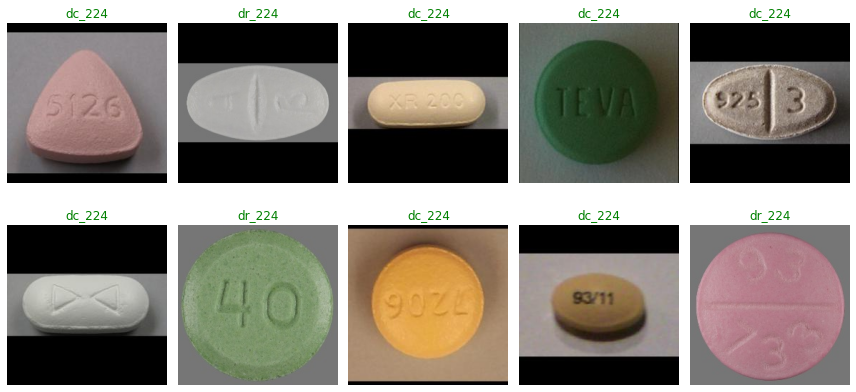

In [ ]:
dataset_directory = os.path.join(os.environ["HOME"], "/content/ePillID_data/classification_data/fcn_mix_weight/")
root_directory = os.path.join(dataset_directory, "")

cat_directory = os.path.join(root_directory, "dc_224")
dog_directory = os.path.join(root_directory, "dr_224")

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))
display_image_grid(test_images_filepaths)

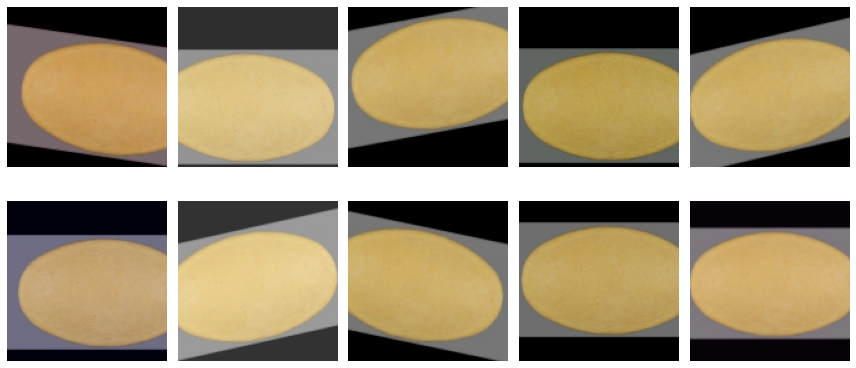

In [ ]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

random.seed(42)
visualize_augmentations(train_dataset)

# Remove bacground

In [ ]:
!wget http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
!wget http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz


In [ ]:
!mkdir mobile_net_model
!mkdir xception_model
!tar xvzf deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz -C mobile_net_model --strip=1
!tar xvzf deeplabv3_pascal_train_aug_2018_01_04.tar.gz -C xception_model --strip=1
!rm deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
!rm deeplabv3_pascal_train_aug_2018_01_04.tar.gz

deeplabv3_mnv2_pascal_train_aug/model.ckpt-30000.index
deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb
deeplabv3_mnv2_pascal_train_aug/model.ckpt-30000.data-00000-of-00001
deeplabv3_pascal_train_aug/model.ckpt.index
deeplabv3_pascal_train_aug/frozen_inference_graph.pb
deeplabv3_pascal_train_aug/model.ckpt.data-00000-of-00001


Trying to open : -f
running deeplab on image /content/ePillID_data/classification_data/fcn_mix_weight/dr_224/00003-4222-16_PART_1_OF_1_CHAL10_SB_F215F93F.jpg...
Time taken to evaluate segmentation is : 0:00:09.715060


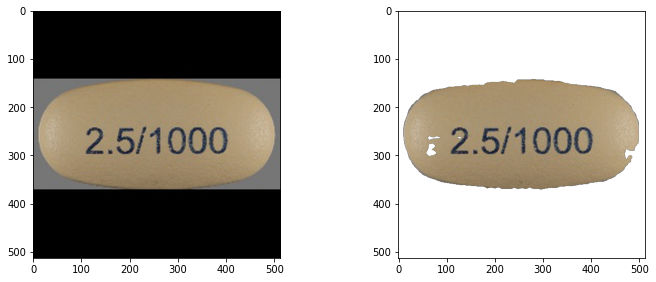

In [ ]:
run_visualization('/content/ePillID_data/classification_data/fcn_mix_weight/dr_224/00003-4222-16_PART_1_OF_1_CHAL10_SB_F215F93F.jpg')

Trying to open : -f
running deeplab on image /content/ePillID_data/classification_data/fcn_mix_weight/dc_224/496.jpg...
Time taken to evaluate segmentation is : 0:00:00.034957


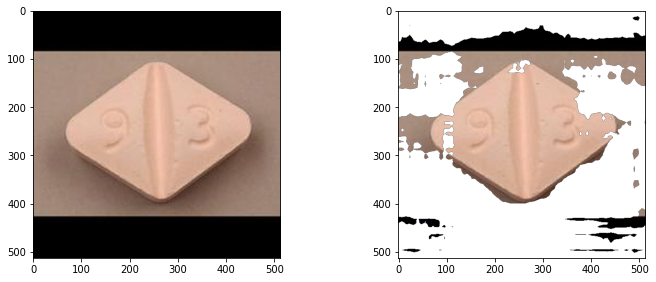

In [ ]:
run_visualization('/content/ePillID_data/classification_data/fcn_mix_weight/dc_224/496.jpg')

---
# End Note

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

time: 215 ms
